## Importing libraries

In [1]:
import numpy as np
import networkx as nx
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.style.use("science")
from scipy.optimize import linprog
import seaborn as sns
import pandas as pd
import networkx as nx

## Optimal transport problem

$$
\begin{array}{c} \text{min}\\Z \in \textbf{N}^{N\text{x}N}\end{array}
\left\{ \sum_{i=1}^{N}\sum_{j=1}^{N} Z_{i,j}C_{i,j} : Z_{i,j} \geq 0 \right\}
$$

Given two distributions $X$ and $Y$ with $\sum_{i}X_{i}=\sum_{j}Y_{j}$ and a cost matrix $C_{ij} = d(x_i, y_j)$.

## Generating a problem

In [2]:
# Number of points
n = 10

In [3]:
# Generate n points in a circle of radius r and center (a, b)
def generate_round(n, a = 0., b = 0., r = 1.0, m = 10, p = 0.8, z_low = 1):
    # Make n odd
    if (n%2 > 0):
        n += 1
    x = np.zeros(n)
    y = np.zeros(n)
    j = 0
    for i in range(n//2):
        sx = a - r + 2 * r * np.random.rand()
        alpha = 1.0
        beta = -2 * b
        gamma = b**2 - r**2 + (sx - a)**2
        # solve alpha * y² + beta * y + gamma = 0
        poly = np.polynomial.Polynomial(np.array([gamma, beta, alpha]))
        y[j], y[j + 1] = poly.roots()
        x[j] = sx
        x[j + 1] = sx
        j += 2
    # Generate the weights from a binomial distribution
    z = np.maximum(np.repeat(z_low, n), np.random.binomial(m, p, n))
    return x,y,z

In [4]:
mu_x, mu_y, mu_z = generate_round(n)

In [5]:
max_z = mu_z.max()

In [6]:
# Generate n points inside a circle of radius r and center (a,b)
def generate_circle(n, a = 3., b = 0., r = 1.0, m = 10, p = 0.6, z_low = 1):
    # Make n odd
    if (n%2 > 0):
        n += 1
    x = (a - r) + 2 * r * np.random.rand(n)
    y = (b - r) + 2 * r * np.random.rand(n)
    # Generate the weights from a poisson distribution
    z = 4 * np.maximum(np.repeat(z_low, n), np.random.poisson(2, n))
    return x,y,z

In [7]:
nu_x, nu_y, nu_z = generate_circle(n)

In [8]:
print(f"Sum nu_z = {nu_z.sum()} and Sum mu_z = {mu_z.sum()}")

Sum nu_z = 92 and Sum mu_z = 78


In [9]:
while nu_z.sum() != mu_z.sum():
    for i in range(n):
        if (nu_z.sum() < mu_z.sum()):
            nu_z[i] += 1
        elif (nu_z.sum() > mu_z.sum()):
            mu_z[i] += 1
        else:
            break

In [10]:
# Check that sum of 
print(mu_z.sum() == nu_z.sum())

True


## Visualization

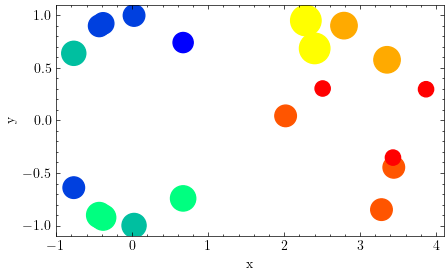

In [11]:
fig = plt.figure(figsize=(5, 3))
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(mu_x, mu_y, s = 30 * mu_z, c = mu_z / max_z, cmap = mpl.colormaps["winter"])
plt.scatter(nu_x, nu_y, s = 30 * nu_z, c = nu_z / max_z, cmap = mpl.colormaps["autumn"])
plt.show()

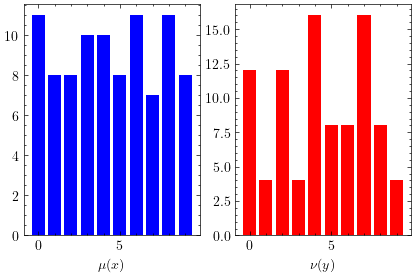

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (5, 3));
axes[0].bar(range(n), mu_z, color = "blue")
axes[0].set_xlabel(r"$\mu(x)$")
axes[1].bar(range(n), nu_z, color = "red", label = "x")
axes[1].set_xlabel(r"$\nu(y)$")
plt.show()

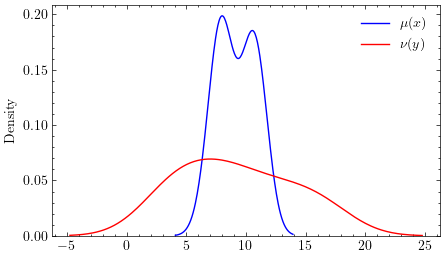

In [13]:
fig = plt.figure(figsize=(5, 3))
sns.kdeplot(mu_z, color = "blue", label = r"$\mu(x)$")
sns.kdeplot(nu_z, color = "red", label = r"$\nu(y)$")
plt.legend()
plt.show()

## Distance matrix

In [14]:
C = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        C[i, j] = np.sqrt((mu_x[i] - nu_x[j])**2 + (mu_y[i] - nu_y[j])**2)

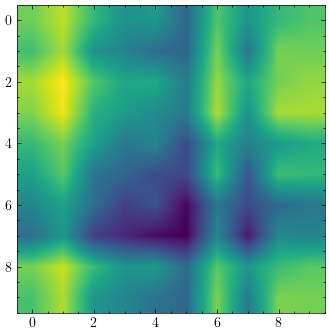

In [15]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(C, interpolation="bilinear")
plt.show()

## Solve the OT problem

Solve the integer linear program (ILP) 

$$
\begin{align}
\text{min} \big\{ <c, z> : p \geq 0, Az = b\big\}
\end{align}
$$

where 
- c is the vectorized distance matrix C
- z is the vectorized matrix Z
- $A = \left[
\begin{array}{c}
I_{N} \otimes 1_{1\text{x}N}\\
1_{1\text{x}N} \otimes I_{N}
\end{array}
\right]$
- and $b=\left[\begin{array}{c}x\\ y \end{array}\right]$

In [16]:
Ax = np.kron(np.identity(n), np.ones(n))
Ay = np.kron(np.ones(n), np.identity(n))
A = np.concatenate((Ax, Ay), 0)
b = np.concatenate((mu_z, nu_z))
c = C.reshape(n * n)

In [17]:
res = linprog(c, A_eq = A, b_eq = b, method = 'highs')

## Visual checking

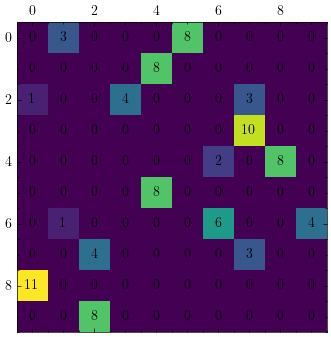

In [18]:
z = res.x
Z = z.reshape((n, n))
plt.matshow(Z)
for i in range(n):
    for j in range(n):
        color = "black"
        plt.text(j,i, int(Z[i,j]), horizontalalignment = 'center',
            verticalalignment = 'center', weight = 'bold', color = color)
plt.show()

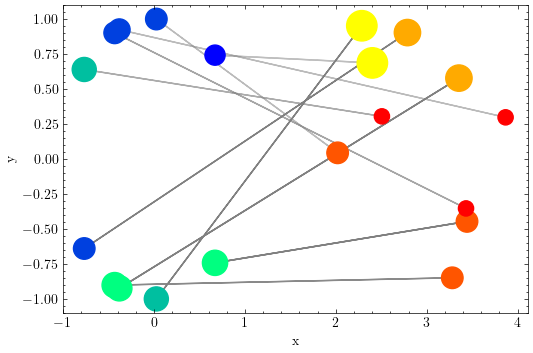

In [19]:
fig = plt.figure(figsize=(6, 4))
plt.xlabel("x")
plt.ylabel("y")
for i in range(n):
    for j in range(n):
        if Z[i, j] > 0. :
            delta_x = nu_x[i] - mu_x[i]
            delta_y = nu_y[i] - mu_y[i]
            plt.arrow(mu_x[i], mu_y[i], delta_x, delta_y, head_width=0.01, color = "grey",
                      alpha = Z[i, j] / Z[:, j].sum())
plt.scatter(mu_x, mu_y, s = 30 * mu_z, c = mu_z / max_z, cmap = mpl.colormaps["winter"])
plt.scatter(nu_x, nu_y, s = 30 * nu_z, c = nu_z / max_z, cmap = mpl.colormaps["autumn"])
plt.show()